# GTO Volley

An exploration into the world of in system setting decisions

In [41]:
# imports and data loading

import pandas as pd 
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt

full = pd.read_csv('dataset_full.csv')
full = full[full.set_location != 'in']
in_system = full.loc[full['pass_rating'] == 'in']
in_system.dropna(subset=['num_blockers'], inplace=True)

C:\Users\tkouk\AppData\Local\Temp\ipykernel_26396\2642509447.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_system.dropna(subset=['num_blockers'], inplace=True)


### Dataset

The dataset used below is originally from the paper "VREN: Volleyball Rally Dataset with Expression Notation Language" by Haotian Xia∗, Rhys Tracy∗, Yun Zhao, Erwan Fraisse, Yuan-Fang Wang, and Linda Petzold (2024). 

The paper can be accessed at: https://arxiv.org/html/2209.13846v2#S3 

The original dataset can be accessed at: https://github.com/haotianxia/VREN

<img src='court_locations.png'>

<Axes: title={'center': 'Pass Locations for In-System Passes'}, xlabel='Court Zone', ylabel='Frequency of Passes'>

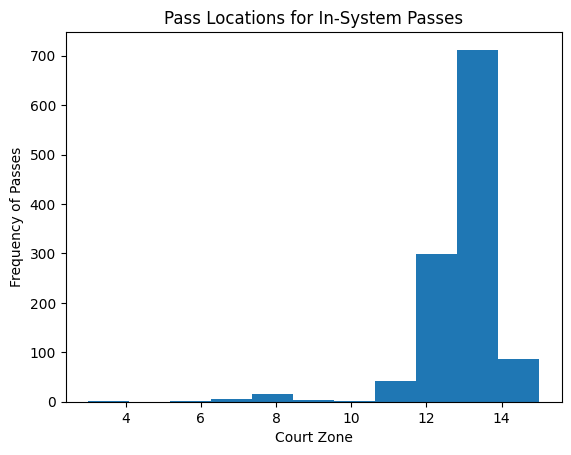

In [3]:
in_system.pass_land_location.plot(kind='hist', bins=11, title='Pass Locations for In-System Passes', xlabel='Court Zone', ylabel='Frequency of Passes')

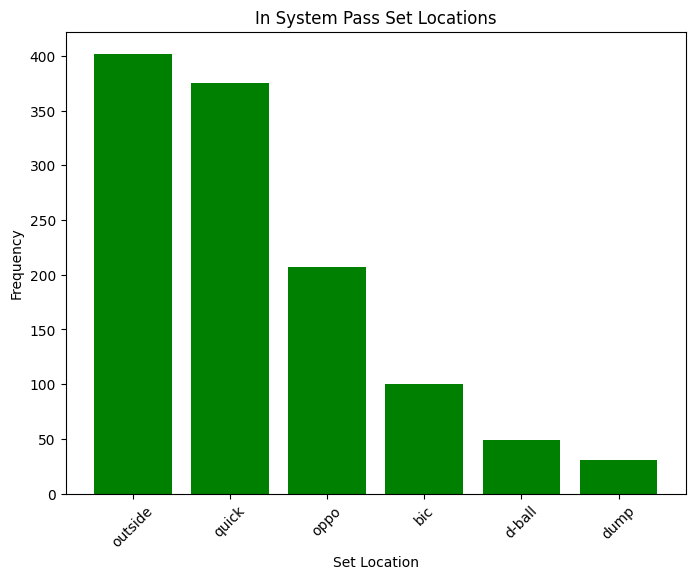

In [4]:
location_counts = in_system.set_location.value_counts()


plt.figure(figsize=(8, 6))
plt.bar(location_counts.index, location_counts.values, color='green')
plt.xlabel('Set Location')
plt.ylabel('Frequency')
plt.title('In System Pass Set Locations')
plt.xticks(rotation=45)
plt.show()

In [5]:
in_system.groupby('set_location').num_blockers.mean()

set_location
bic        1.970000
d-ball     1.755102
dump       0.967742
oppo       1.835749
outside    1.827930
quick      1.532086
Name: num_blockers, dtype: float64

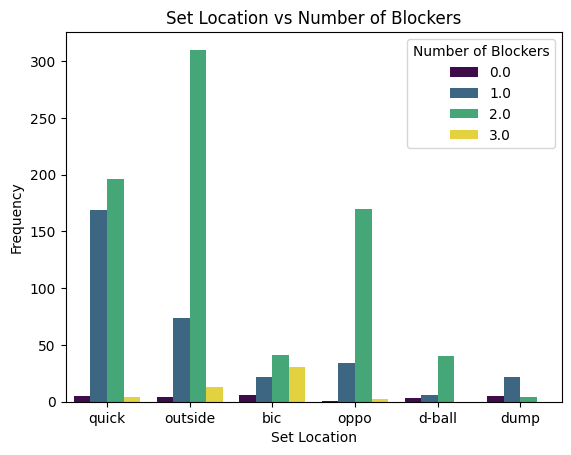

In [42]:
sns.countplot(
    data=in_system,
    x='set_location',
    hue='num_blockers',
    palette='viridis'  # you can try 'coolwarm', 'Set2', etc.
)

plt.title('Set Location vs Number of Blockers')
plt.xlabel('Set Location')
plt.ylabel('Frequency')
plt.legend(title='Number of Blockers')
plt.show()

### Search for an Equilibrium

For the purposes of this exploration, I will treat in system setting decisions as a two player game with incomplete information. 

A setter's job is to give his attackers/team the best chance of scoring on every play. 

In this simplified version of events, we will consider the setters Action Set $A_1$ to be his choice of set location {Outside, Middle, Pipe, Right Side, C-ball, Dump}
    
    - Note that within each of these broad categories, there are different types of sets possible, most notably to the middle (30, 50, 60, slide, etc.) 

The utility function for the setter $U_1$ is the expected payoff of the setting choice, given the blocker response, or $P(Point_{location}\: | \: Number \: of \: Blockers)$.

Given that each point in volleyball is zero sum, the payoff for the blocker response is inverse to that of the setter, or $ 1- P(Point_{location}\: | \: Number \: of \: Blockers)$.


In [ ]:
from solver import *

To find the payoffs for the setter, I will need to determine the expected points in each setting scenario, taking into account both set location and the number of blockers. 

In [60]:
def find_payoff(location: str, num_blockers: float) -> float:
    """Calculate expected points for a given set location and number of blockers."""
    subset = in_system[
        (in_system['set_location'] == location) & 
        (in_system['num_blockers'] == num_blockers)
    ]
    if len(subset) == 0:
        return None # a default value indication no data

    outcomes = subset.groupby('team').winning_team.value_counts()
    try:
        expected_point = (outcomes.a.a + outcomes.b.b) / outcomes.sum().sum()
    except: 
        expected_point = 0.0

        if outcomes.isin(['a']).any():
            if outcomes.a.isin(['a']).any():
                expected_point += outcomes.a.a / outcomes.sum()
            else:
                expected_point += 0.0

        if outcomes.isin(['b']).any():
            if outcomes.b.isin(['b']).any():
                expected_point += outcomes.b.b / outcomes.sum()
            else:
                expected_point += 0.0

    if expected_point == 0.0:
        return None # a default value indication no data
    
    return expected_point
    

In [ ]:
possible_gamestates = [(loc, blockers) for loc in in_system.set_location.unique() for blockers in in_system.num_blockers.unique()]

setter_payoffs = {
    gamestate: find_payoff(gamestate[0], gamestate[1]) 
    for gamestate in possible_gamestates
}

filtered = {k: v for k, v in setter_payoffs.items() if v is not None}

setter_payoffs.clear()
setter_payoffs.update(filtered)

blocker_payoffs = {k: 1 - v for k, v in setter_payoffs.items()}